In [1]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout

/Data/ml_env/miniconda3/envs/venv_ml_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Data/ml_env/miniconda3/envs/venv_ml_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reproducing an image

In [2]:
img = Image.open("examples/input.png")

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

Using cpu


In [4]:
def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [6]:
model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

Using attention_rollout


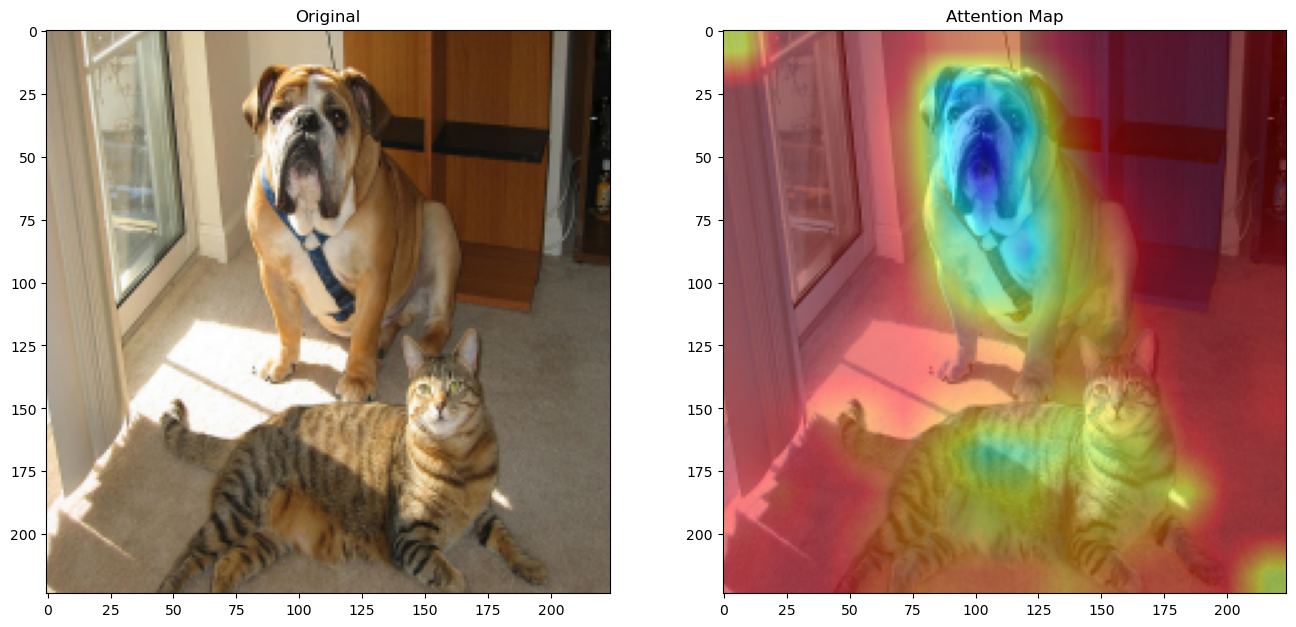

In [7]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_rollout" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("examples/input.png", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

## Understanding the plot

In [8]:
np.array(img).shape

(224, 224, 3)

In [9]:
np.array(img)[:,:,::-1].shape # but they are inversed? -> to correct channel ordering to fit opencv one

(224, 224, 3)

# Attention Rollout, understanding algorithm

In [10]:
attention_rollout.attentions[-1].shape

torch.Size([1, 3, 197, 197])

## Experimenting with one attention layer

In [11]:
single_attention = attention_rollout.attentions[0]

In [12]:
single_attention.shape

torch.Size([1, 3, 197, 197])

In [13]:
single_attention.mean(axis = 1).shape

torch.Size([1, 197, 197])

In [14]:
single_attention.max(axis = 1)

torch.return_types.max(
values=tensor([[[0.2021, 0.0110, 0.0089,  ..., 0.0055, 0.0062, 0.0093],
         [0.3885, 0.2127, 0.0742,  ..., 0.0074, 0.0091, 0.0093],
         [0.3714, 0.1185, 0.0957,  ..., 0.0063, 0.0076, 0.0081],
         ...,
         [0.3617, 0.0058, 0.0022,  ..., 0.0911, 0.0761, 0.0742],
         [0.3635, 0.0060, 0.0022,  ..., 0.0666, 0.0900, 0.1315],
         [0.3817, 0.0061, 0.0025,  ..., 0.0330, 0.0660, 0.1950]]]),
indices=tensor([[[1, 0, 0,  ..., 2, 0, 0],
         [2, 0, 0,  ..., 1, 1, 1],
         [2, 0, 0,  ..., 1, 1, 1],
         ...,
         [2, 1, 1,  ..., 0, 0, 0],
         [2, 1, 1,  ..., 0, 0, 0],
         [2, 1, 1,  ..., 0, 0, 0]]]))

In [15]:
attention_heads_fused = single_attention.max(axis = 1)[0]

In [16]:
discard_ratio = 0.9

print(attention_heads_fused.sum())

flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
_, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
indices = indices[indices != 0]
flat[0, indices] = 0

print(attention_heads_fused.sum())

tensor(365.9828)
tensor(183.5572)


We see that indeed the flatten was simply to easily locate the elements

In [17]:
I = torch.eye(attention_heads_fused.size(-1))
I.shape

torch.Size([197, 197])

In [18]:
a = (attention_heads_fused + 1.0*I)/2

In [19]:
a.shape

torch.Size([1, 197, 197])

In [20]:
I = torch.eye(attention_heads_fused.size(-1))
a = (attention_heads_fused + 1.0*I)/2

In [21]:
a[0].sum(axis = 1)

tensor([0.6011, 1.0043, 0.9775, 1.0068, 1.0019, 0.9816, 0.9798, 0.9834, 1.0028,
        0.9561, 0.9831, 0.9707, 0.9630, 0.9913, 1.0013, 0.9730, 0.9590, 0.9689,
        0.9897, 0.9615, 1.0401, 0.9669, 0.9683, 0.9704, 0.9730, 0.9642, 0.9471,
        0.9727, 0.9860, 0.9818, 0.9627, 0.9681, 0.9776, 0.9525, 0.9999, 0.9946,
        0.9759, 0.9520, 0.9659, 0.9576, 0.9617, 0.9787, 0.9911, 0.9783, 0.9694,
        0.9649, 0.9607, 0.9638, 0.9676, 0.9844, 0.9725, 0.9524, 0.9521, 0.9582,
        0.9602, 0.9806, 0.9870, 0.9739, 0.9697, 0.9719, 0.9695, 0.9698, 0.9677,
        0.9813, 0.9532, 0.9436, 0.9583, 0.9454, 0.9444, 0.9769, 0.9982, 0.9813,
        0.9593, 0.9637, 0.9672, 0.9706, 0.9551, 0.9919, 0.9610, 0.9418, 0.9442,
        0.9504, 0.9468, 0.9745, 0.9836, 0.9739, 0.9690, 0.9454, 0.9576, 0.9557,
        0.9589, 0.9705, 0.9707, 0.9472, 0.9618, 0.9476, 0.9453, 0.9656, 0.9860,
        0.9752, 0.9570, 0.9490, 0.9592, 0.9609, 0.9599, 0.9500, 0.9555, 0.9476,
        0.9476, 0.9647, 0.9531, 0.9652, 

In [22]:
a.sum(dim = -1, keepdim=True).shape

torch.Size([1, 197, 1])

In [23]:
B = a / a.sum(dim=-1)


In [24]:
C = a / a.sum(dim=-1, keepdim=True)

In [25]:
B

tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3232, 0.6038, 0.0380,  ..., 0.0000, 0.0000, 0.0000],
         [0.3090, 0.0590, 0.5605,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.3009, 0.0000, 0.0000,  ..., 0.5639, 0.0393, 0.0381],
         [0.3024, 0.0000, 0.0000,  ..., 0.0344, 0.5622, 0.0676],
         [0.3176, 0.0000, 0.0000,  ..., 0.0170, 0.0340, 0.6141]]])

In [26]:
C

tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1934, 0.6038, 0.0370,  ..., 0.0000, 0.0000, 0.0000],
         [0.1900, 0.0606, 0.5605,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1869, 0.0000, 0.0000,  ..., 0.5639, 0.0393, 0.0383],
         [0.1875, 0.0000, 0.0000,  ..., 0.0344, 0.5622, 0.0678],
         [0.1962, 0.0000, 0.0000,  ..., 0.0169, 0.0339, 0.6141]]])

In [27]:
a[0].sum(axis = 1)

tensor([0.6011, 1.0043, 0.9775, 1.0068, 1.0019, 0.9816, 0.9798, 0.9834, 1.0028,
        0.9561, 0.9831, 0.9707, 0.9630, 0.9913, 1.0013, 0.9730, 0.9590, 0.9689,
        0.9897, 0.9615, 1.0401, 0.9669, 0.9683, 0.9704, 0.9730, 0.9642, 0.9471,
        0.9727, 0.9860, 0.9818, 0.9627, 0.9681, 0.9776, 0.9525, 0.9999, 0.9946,
        0.9759, 0.9520, 0.9659, 0.9576, 0.9617, 0.9787, 0.9911, 0.9783, 0.9694,
        0.9649, 0.9607, 0.9638, 0.9676, 0.9844, 0.9725, 0.9524, 0.9521, 0.9582,
        0.9602, 0.9806, 0.9870, 0.9739, 0.9697, 0.9719, 0.9695, 0.9698, 0.9677,
        0.9813, 0.9532, 0.9436, 0.9583, 0.9454, 0.9444, 0.9769, 0.9982, 0.9813,
        0.9593, 0.9637, 0.9672, 0.9706, 0.9551, 0.9919, 0.9610, 0.9418, 0.9442,
        0.9504, 0.9468, 0.9745, 0.9836, 0.9739, 0.9690, 0.9454, 0.9576, 0.9557,
        0.9589, 0.9705, 0.9707, 0.9472, 0.9618, 0.9476, 0.9453, 0.9656, 0.9860,
        0.9752, 0.9570, 0.9490, 0.9592, 0.9609, 0.9599, 0.9500, 0.9555, 0.9476,
        0.9476, 0.9647, 0.9531, 0.9652, 

## All layers

In [107]:
attentions = attention_rollout.attentions
discard_ratio = 0.9

In [109]:
result = torch.eye(attentions[0].size(-1))
with torch.no_grad():
    for attention in attentions:
        attention_heads_fused = attention.mean(axis=1)

        # Drop the lowest attentions, but
        # don't drop the class token
        flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
        _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
        indices = indices[indices != 0]
        flat[0, indices] = 0

        I = torch.eye(attention_heads_fused.size(-1))
        a = (attention_heads_fused + 1.0*I)/2
        a = a / a.sum(dim=-1)
        # a = a / a.sum(dim=-1, keepdim=True)

        result = torch.matmul(a, result)

# Look at the total attention between the class token,
# and the image patches
mask = result[0, 0 , 1 :] # [0: batch(1 image),  ]
# In case of 224x224 image, this brings us from 196 to 14 $$ not my comment
width = int(mask.size(-1)**0.5)
mask = mask.reshape(width, width).numpy()
mask = mask / np.max(mask)

SyntaxError: 'return' outside function (2501374499.py, line 23)

In [110]:
mask.shape

torch.Size([196])

In [ ]:
result[0, ]

In [14]:
result.shape

torch.Size([1, 197, 197])

# Trying graph

In [111]:
import maxflow
attentions = attention_rollout.attentions
discard_ratio = 0

In [112]:
def compute_a_matrices(attentions, discard_ratio, head_fusion):
    '''Generates the A matrices as in the paper from the attention layers
    '''
    a_matrices = []
    
    for attention in attentions:
        # Getting type of fusion of channels
        if head_fusion == "mean":
            attention_heads_fused = attention.mean(axis=1)
        elif head_fusion == "max":
            attention_heads_fused = attention.max(axis=1)[0]
        elif head_fusion == "min":
            attention_heads_fused = attention.min(axis=1)[0]
        else:
            raise "Attention head fusion type Not supported"
        
        # Drop the lowest attentions, but
        # don't drop the class token
        flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
        _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
        indices = indices[indices != 0]
        flat[0, indices] = 0
        
        
        I = torch.eye(attention_heads_fused.size(-1))
        a = (attention_heads_fused + 1.0*I)/2
        
        a = a / a.sum(dim=-1)
        # a = a / a.sum(dim=-1, keepdim=True) -> verify which one is correct
        
        a_matrices.append(a)  
    
    return a_matrices

In [113]:
a_matrices = compute_a_matrices(attentions, discard_ratio, 'mean')

In [114]:
a_matrices[-1].shape

torch.Size([1, 197, 197])

In [176]:
n_tokens = a_matrices[0].size(-1)
n_layers = len(a_matrices)

INPUT_FLOW = 1.4
OUTPUT_FLOW_NODE = INPUT_FLOW / n_tokens

n_nodes = n_layers * n_tokens
n_nodes_plus = n_nodes + 1 # Necessary if we put 1 in "CLS" node

n_vertices = int((1 - discard_ratio) * n_tokens**2 + 1)

print(n_nodes)
print(n_vertices)

g = maxflow.Graph[float](n_nodes_plus, n_vertices) ## no CLS -> pass n_nodes
nodes = g.add_nodes(n_nodes_plus) ## no CLS -> pass n_nodes

## Setting first nodes who will be sink

for i in range(n_tokens):
    g.add_tedge(nodes[i], 0., OUTPUT_FLOW_NODE)
    
## Setting final nodes who will be source
source_weights = a_matrices[-1][0, 0, :] # assuming it includes classification token
for idx, node_number in enumerate(range(n_nodes - n_tokens, n_nodes)):
    # g.add_tedge(nodes[node_number], source_weights[idx], 0)
    # Instead of assuming all flow from source, we send a node that has all information
    g.add_edge(nodes[node_number], nodes[nodes[n_nodes]], 0, source_weights[idx]) ## CLS

g.add_tedge(nodes[n_nodes], INPUT_FLOW, 0) ## CLS   

## Setting internal nodes

for n_layer, a_matrix in enumerate(a_matrices):
    if n_layer == n_layers - 1: break
    
    start_node = n_layer * n_tokens
    start_node_next = (n_layer + 1) * n_tokens
    
    for idx_x, node_number in enumerate(range(start_node, start_node + n_tokens)):
        weights = a_matrix[0,idx_x,:]
        
        for idx_y in range(n_tokens):
            weight = weights[idx_y]
            
            if weight == 0: continue
            
            node_number_next = start_node_next + idx_y
            g.add_edge(nodes[node_number], nodes[node_number_next], 0., weight) # next layer points to layer before
            
initial_graph = g.get_nx_graph()

max_flow = g.maxflow()
print(max_flow)

final_graph = g.get_nx_graph()

mask_attention_flow = np.zeros(n_tokens)

for node_number in range(0, n_tokens):
    if 't' not in final_graph.adj[node_number].keys():
        mask_attention_flow[node_number] = initial_graph.adj[node_number]['t']['weight']
    else:
        mask_attention_flow[node_number] = initial_graph.adj[node_number]['t']['weight'] - final_graph.adj[node_number]['t']['weight']
        
mask = torch.Tensor(mask_attention_flow[1:])

width = int(mask.size(-1)**0.5)
mask = mask.reshape(width, width).numpy()
mask = mask / np.max(mask)

2364
38810
1.0000000440923036


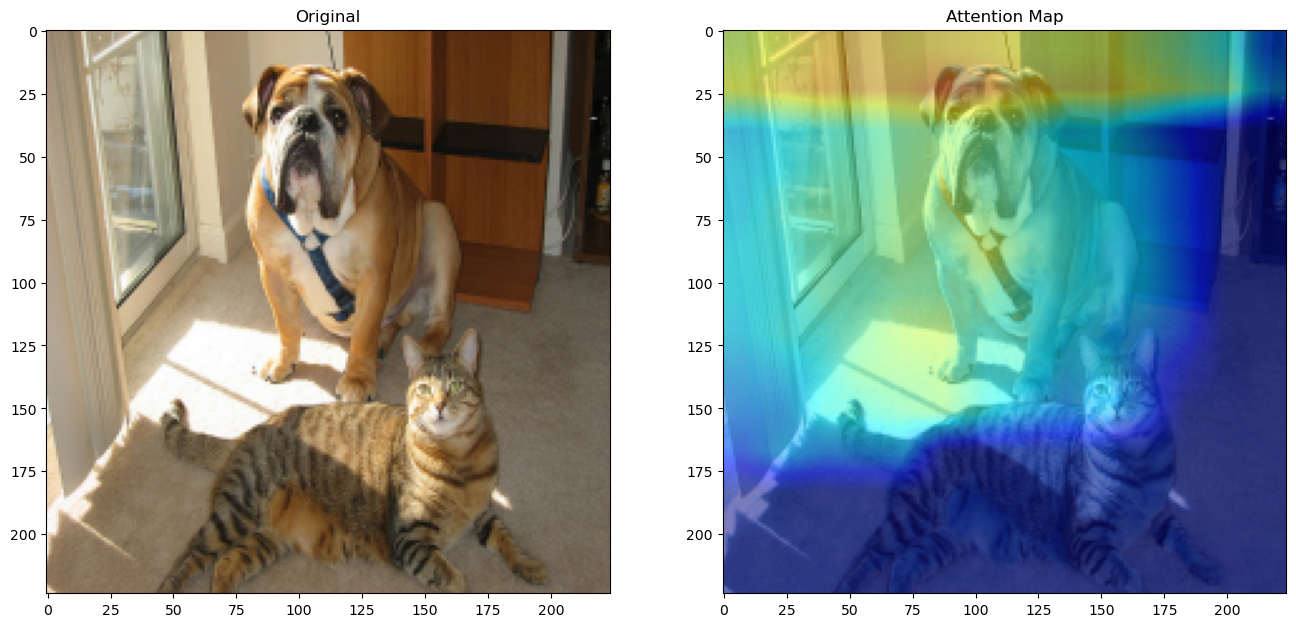

In [177]:
np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

# Getting classes

In [27]:
output = model(input_tensor)

In [29]:
output.shape

torch.Size([1, 1000])

In [55]:
import requests
import torch.nn.functional as F

LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

scores = model(input_tensor)

def print_preds(scores):
    # print the predictions with their 'probabilities' from the scores
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

_ = print_preds(scores)

0.266 -> ['n02108422', 'bull_mastiff']
0.062 -> ['n02108089', 'boxer']
0.039 -> ['n02123159', 'tiger_cat']
0.033 -> ['n02110958', 'pug']
0.023 -> ['n02123045', 'tabby']


# Remarks

So basically, raw attention we only need to look at the attentions correspondent to the class token.... 
Attention rollout we will perform the matrix multiplications to also get the attention flow thoroughout all layers